In [151]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [152]:
#Essentials
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import matplotlib.pyplot as plt

#sklearn "magic"
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline

#Oversampling
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN


#Not sure about these ones yet
from sklearn.datasets import make_classification
from xgboost import XGBClassifier

#Different scores
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, f1_score, fbeta_score, roc_curve

#Nice to have
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
import seaborn as sns
plt.style.use('fivethirtyeight')
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display 
from ipywidgets import interactive, FloatSlider
from collections import Counter
#interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

#Let there be colours!
from termcolor import colored

%matplotlib inline

In [153]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [154]:
# Postgres info to connect

connection_args = {
    'host': '18.222.192.127', 
    'user': 'ubuntu',    # username
    'dbname': 'student_grades',   # DB that we are connecting to
    'port': 5432         # port we opened on AWS
}

# We will talk about this magic Python trick!
connection = pg.connect(**connection_args)

In [155]:
#failures: 0.275, higher: 0.102, discipline: 0.09, absences: 0.081, goout: 0.041, age: 0.038, Fedu: 0.037, Medu: 0.033, freetime: 0.03
#Walc: 0.026, famrel: 0.025, Dalc: 0.025, health: 0.023, guardian: 0.021, schoolsup: 0.021, paid: 0.018, studytime: 0.017, traveltime: 0.016
#activities: 0.015, sex: 0.013, address: 0.011, famsize: 0.011, romantic: 0.011, famsup: 0.01, internet: 0.009, Pstatus: 0.003

In [156]:
### Let's combine the two SQL tables into one

append_query = """SELECT * --failures, final_grade_label 
                    FROM maths_grades
                    WHERE age BETWEEN 15 AND 19

                    UNION ALL

                    SELECT * --failures, final_grade_label 
                    FROM portuguese_grades
                    WHERE age BETWEEN 15 AND 19
                    """

grades = pd_sql.read_sql(append_query, connection)

In [157]:
grades.head()

,sex,age,address,famsize,Pstatus,Medu,Fedu,guardian,traveltime,studytime,...,freetime,goout,Dalc,Walc,health,absences,G3,discipline,final_grade_label,final_grade_segment
0,F,18,U,GT3,A,4,4,mother,2,2,...,3,4,1,1,3,6,6,maths,Fail,Fail
1,F,17,U,GT3,T,1,1,father,1,2,...,3,3,1,1,3,4,6,maths,Fail,Fail
2,F,15,U,LE3,T,1,1,mother,1,2,...,3,2,2,3,3,10,10,maths,Pass,Sufficient
3,F,15,U,GT3,T,4,2,mother,1,3,...,2,2,1,1,5,2,15,maths,Pass,Good
4,F,16,U,GT3,T,3,3,father,1,2,...,3,2,1,2,5,4,10,maths,Pass,Sufficient


### Let's dummify some variables

In [158]:
#Sanity check
grades.columns

Index(['sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup',
       'famsup', 'paid', 'activities', 'higher', 'internet', 'romantic',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
       'G3', 'discipline', 'final_grade_label', 'final_grade_segment'],
      dtype='object')

In [159]:
#dummify sex (M=0, F=1)
grades['sex'].replace({'M': 0, 'F': 1}, inplace=True)

#dummify address (U(urban)=0, R(rural)=1)
grades['address'].replace({'U': 0, 'R': 1}, inplace=True)

#dummify famsize (LE3(less than/equal to 3)=0, GT3(greater than 3)=1)
grades['famsize'].replace({'LE3': 0, 'GT3': 1}, inplace=True)

#dummify Pstatus(parent status) (T(together)=0, A(apart)=1)
grades['Pstatus'].replace({'T': 0, 'A': 1}, inplace=True)

#dummify guardian (other=0, mother=1, father=2)
grades['guardian'].replace({'other': 0, 'mother': 1, 'father': 2}, inplace=True)

#dummify discipline (maths=0, portuguese=1)
grades['discipline'].replace({'maths': 0, 'portuguese': 1}, inplace=True)

#drop G3 column (obviously!)
grades.drop(columns='G3', inplace=True)

#dummify target variable
grades['final_grade_label'].replace({'Fail': 0, 'Pass': 1}, inplace=True)


### Feature and target analysis

In [160]:
print(grades['final_grade_label'].value_counts(), '\n')
print('% of Pass:', str(round(814 / 1044, 2)))
print('% of Fail:', str(round(230 / 1044, 2)), '\n')
print('Pass to Fail ratio in the dataset:', str(int((814 / 1044)*100))+':'+str(int((230 / 1044)*100)))
print('Percentage of Majority grade (Pass)', str(round((814 / 1044) *100, 0)))

1    804
0    226
Name: final_grade_label, dtype: int64 

% of Pass: 0.78
% of Fail: 0.22 

Pass to Fail ratio in the dataset: 77:22
Percentage of Majority grade (Pass) 78.0


> **This is not good!** I should look into oversampling or undersampling further down the line

In [161]:
feat, grade_label = grades.iloc[:, :-2], grades.iloc[:, -2]

In [162]:
# print(feat.head())
# print(grade_label.head())

In [163]:
#grades.corr()

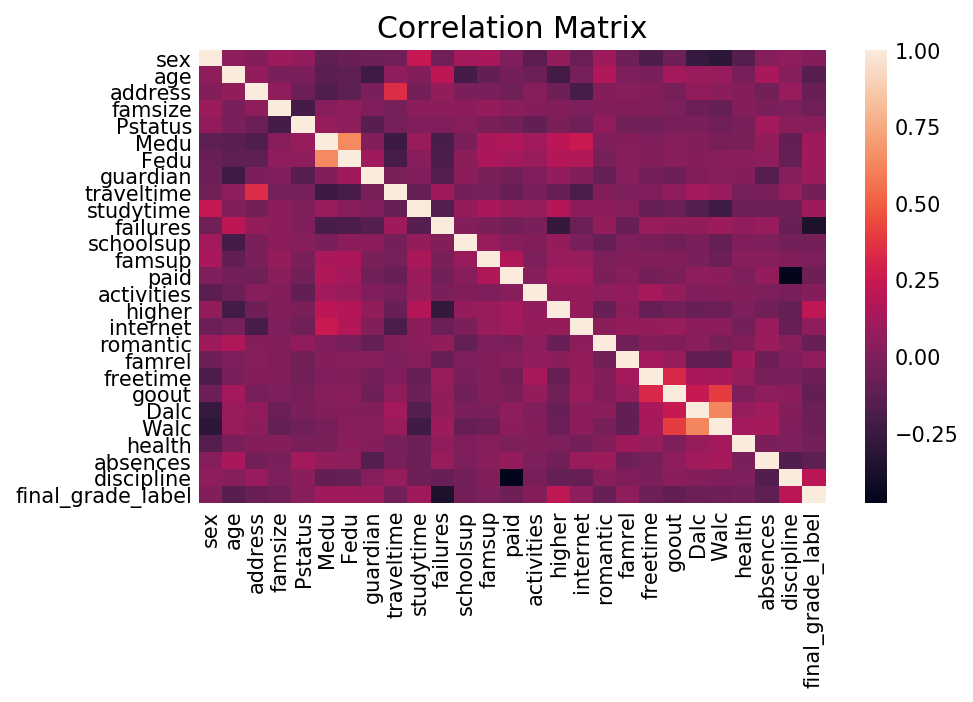

In [164]:
plt.figure(dpi=150)
plt.title('Correlation Matrix')
corr = grades.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

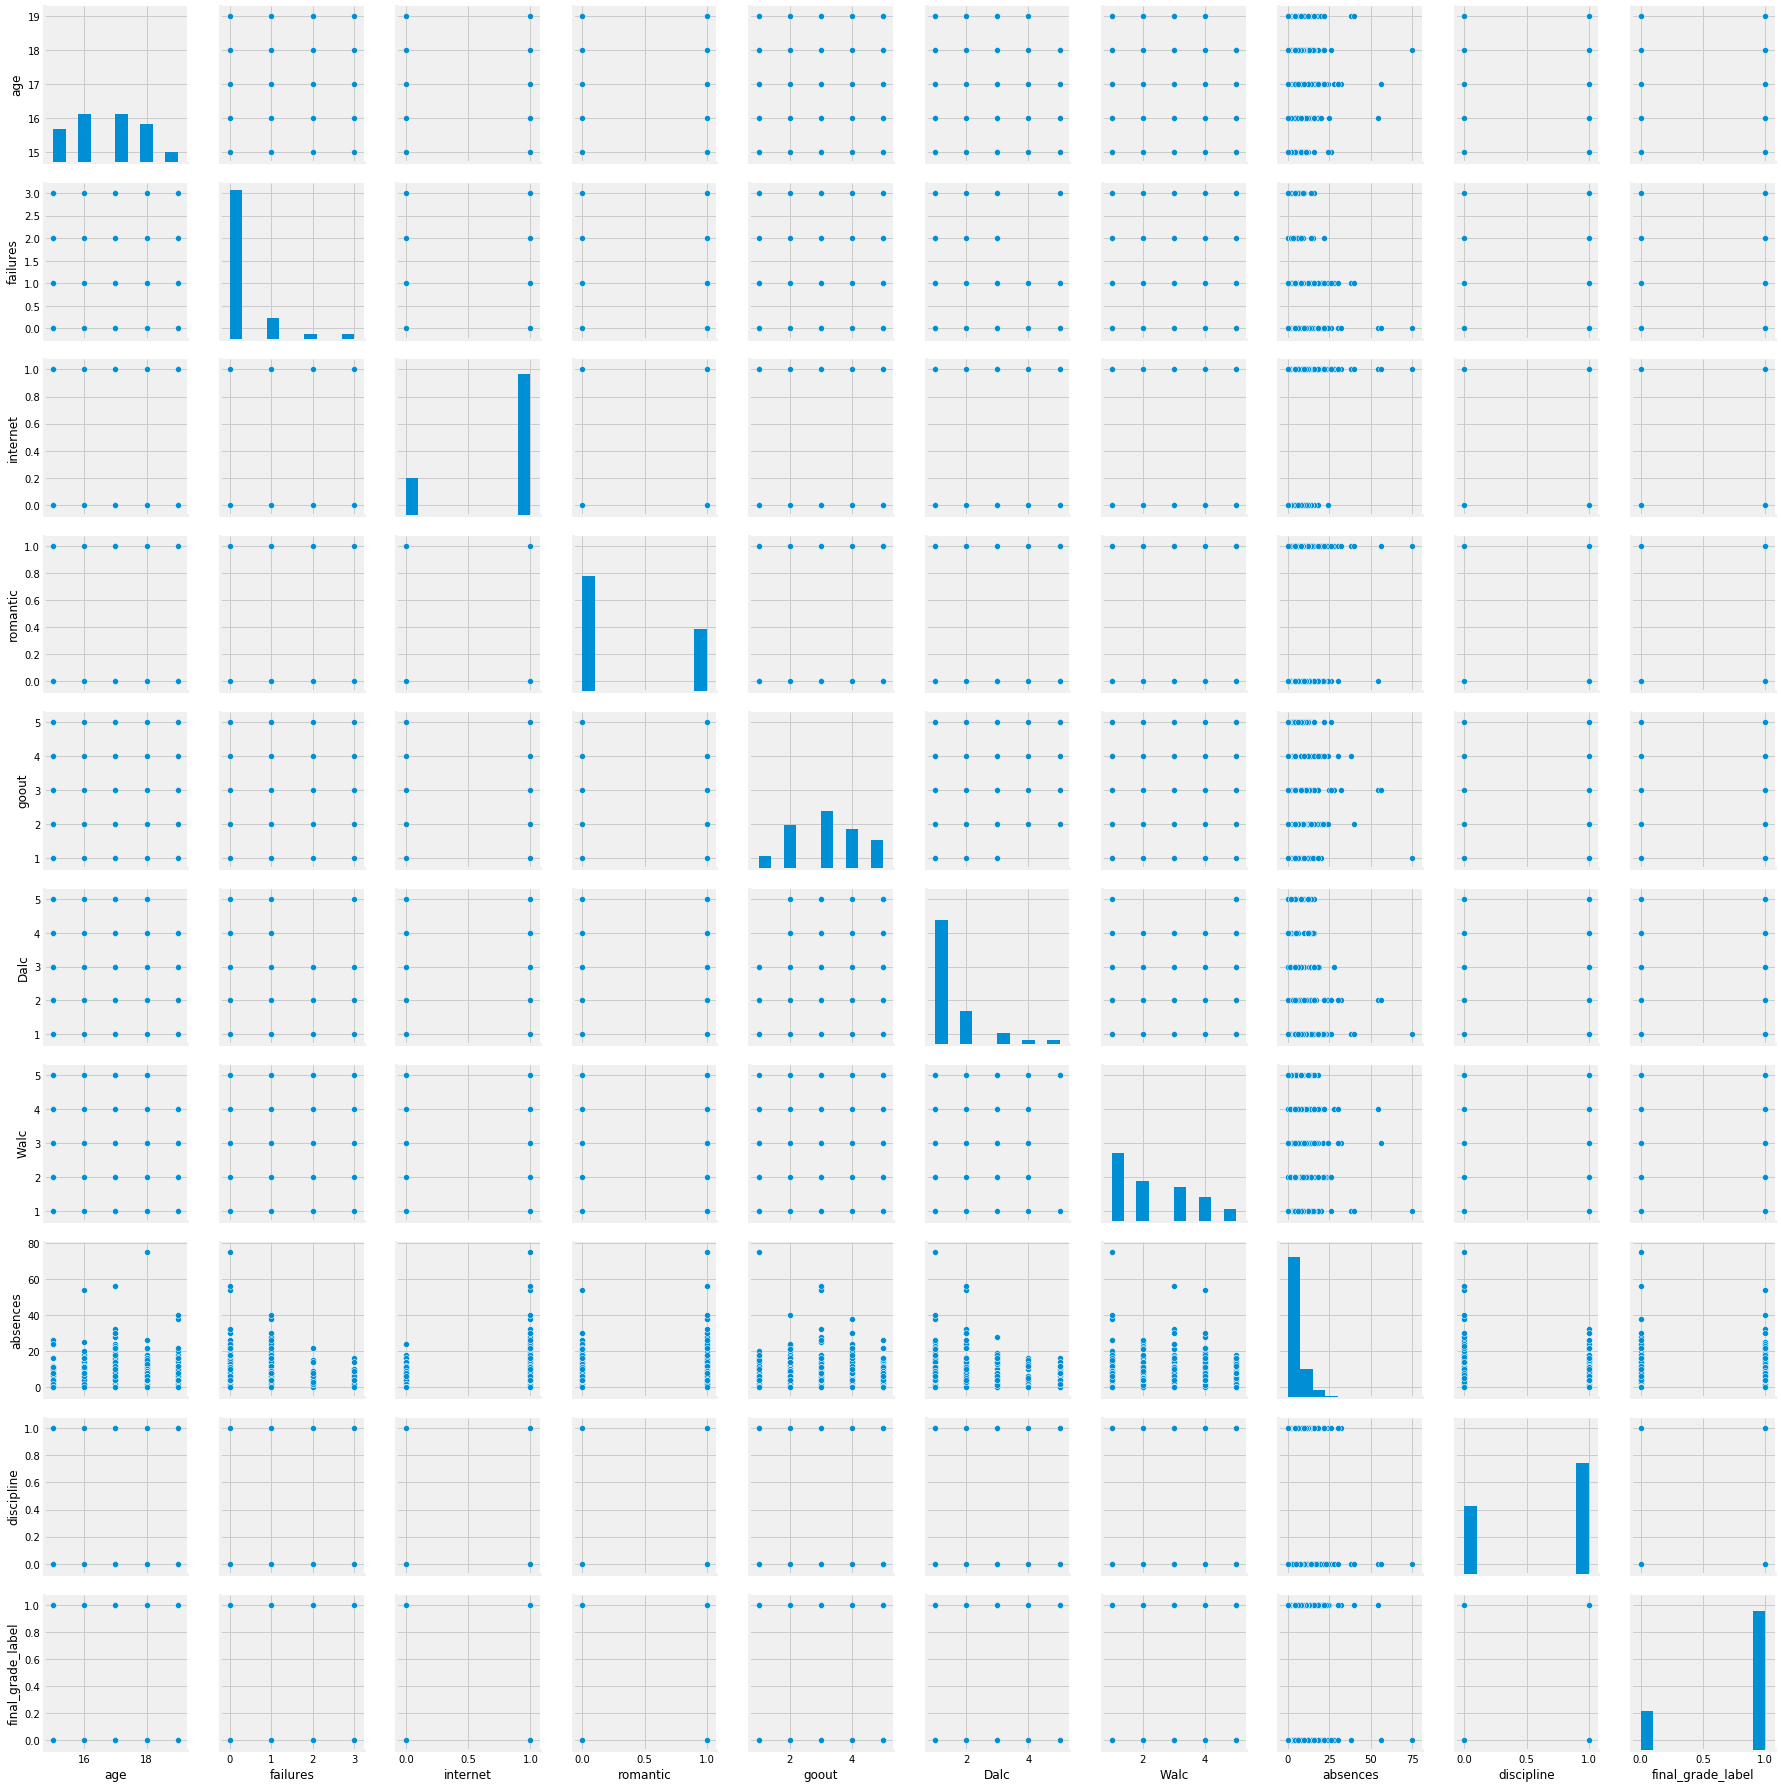

In [165]:
sns.pairplot(grades[['age', 'failures', 'internet', 'romantic', 'goout', 'Dalc', 'Walc', 'absences', 'discipline', 'final_grade_label']]);

# 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
#        'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup',
#        'famsup', 'paid', 'activities', 'higher', 'internet', 'romantic',
#        'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
#        'discipline', 'final_grade_label', 'final_grade_segment'

## Train - test split

In [166]:
feat_train, feat_test, grade_label_train, grade_label_test = train_test_split(feat, grade_label, test_size=0.2
                                                                                  , random_state=42, stratify=grade_label)

# Modelling Time

### Identifying best hyper-parameters

**KNN Classifier (in search for the optimal k)**

In [167]:
k_range = range(1, 31)
weight_options = ['uniform', 'distance']
param_grid_knn = dict(n_neighbors=k_range, weights=weight_options)

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, scoring='precision')
grid_knn.fit(feat_train, grade_label_train);

In [168]:
# examine the best model
print('Best precision score for knn cross validation is', colored(str(round(grid_knn.best_score_, 3)), 'magenta')+ '.')
print('Best parameters for knn cross validation are', colored(str(grid_knn.best_params_), 'magenta')+ '.')
print('Best estimators for knn cross validation are the following:\n\t', colored(str(grid_knn.best_estimator_), 'magenta'))

Best precision score for knn cross validation is 0.803.
Best parameters for knn cross validation are {'n_neighbors': 4, 'weights': 'uniform'}.
Best estimators for knn cross validation are the following:
	 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')


**Logistic Regression Classifier (in search for the optimal hypers)**

In [169]:
penalties = ['l1', 'l2']
C_range = [1e-04, 1e-03, 1e-02, 0.1, 1.0, 10.0]
weights = [None, 'balanced']
iterations = [1, 2, 5, 10, 20, 40, 60]
param_grid_LogReg = dict(penalty=penalties, C=C_range, class_weight=weights, max_iter=iterations)

grid_LogReg = GridSearchCV(LogisticRegression(random_state=42), param_grid_LogReg, scoring='average_precision')
grid_LogReg.fit(feat_train, grade_label_train);

In [170]:
# examine the best model
print('Best avg. precision score for Logistic Regression cross validation is', colored(str(round(grid_LogReg.best_score_, 3)), 'magenta')+ '.')
print('Best parameters for Logistic Regression cross validation are:\n\t', colored(str(grid_LogReg.best_params_), 'magenta')+ '.')
print('Best estimators for Logistic Regression cross validation are the following:\n\t', colored(str(grid_LogReg.best_estimator_), 'magenta'))

Best avg. precision score for Logistic Regression cross validation is 0.916.
Best parameters for Logistic Regression cross validation are:
	 {'C': 10.0, 'class_weight': None, 'max_iter': 5, 'penalty': 'l1'}.
Best estimators for Logistic Regression cross validation are the following:
	 LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


**Random Forest Classifier (in search for the optimal hypers)**

In [171]:
estimators = [150] #tried [2, 5, 10, 20, 40, 50, 100, 150]
depth = [20] #tried [2, 5, 10, 20, 30, 40]
leaf_samples = [10] #tried [1, 2, 3, 4, 5, 10]
samples = [2] #tried [2, 3, 4, 5, 10]
weights = ['balanced'] #tried ['balanced', None]
param_grid_RandFor = dict(n_estimators=estimators, max_depth=depth, min_samples_leaf=leaf_samples, min_samples_split=samples, class_weight=weights)

grid_RandFor = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_RandFor, scoring='precision')
grid_RandFor.fit(feat_train, grade_label_train);

In [172]:
# examine the best model
print('Best precision score for Random Forest cross validation is', colored(str(round(grid_RandFor.best_score_, 3)), 'magenta')+ '.')
print('Best parameters for Random Forest cross validation are:\n\t', colored(str(grid_RandFor.best_params_), 'magenta'))
print('Best estimators for Random Forest cross validation are the following:\n\t', colored(str(grid_RandFor.best_estimator_), 'magenta'))

Best precision score for Random Forest cross validation is 0.874.
Best parameters for Random Forest cross validation are:
	 {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 150}
Best estimators for Random Forest cross validation are the following:
	 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)


**Support Vector Classification (SVC) (in search for the optimal hypers)**

In [173]:
C_range = [0.001, 0.01, 0.1, 1.0, 2.0, 3.0, 5.0, 8.0, 10.0, 15.0] #tried [0.001, 0.01, 0.1, 1.0, 2.0, 3.0, 5.0]
kernel_range = ['poly'] #tried ['linear', 'poly', 'rbf', 'sigmoid']
degree_range = [1] #tried [1, 2, 3, 4, 7]
probs = [True] #tried [True, False]
weights = ['balanced'] #tried ['balanced', None]
param_grid_SVC = dict(C=C_range, kernel=kernel_range, degree=degree_range, probability=probs, class_weight=weights)

grid_SVC = GridSearchCV(SVC(random_state=42), param_grid_SVC, scoring='average_precision')
grid_SVC.fit(feat_train, grade_label_train);

In [174]:
# examine the best model
print('Best precision score for SVC cross validation is', colored(str(round(grid_SVC.best_score_, 3)), 'magenta')+ '.')
print('Best parameters for SVC cross validation are:\n\t', colored(str(grid_SVC.best_params_), 'magenta'))
print('Best estimators for SVC cross validation are the following:\n\t', colored(str(grid_SVC.best_estimator_), 'magenta'))

Best precision score for SVC cross validation is 0.911.
Best parameters for SVC cross validation are:
	 {'C': 5.0, 'class_weight': 'balanced', 'degree': 1, 'kernel': 'poly', 'probability': True}
Best estimators for SVC cross validation are the following:
	 SVC(C=5.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)


**Naive Bayes Bernoulli (NBB) (in search for the optimal hypers)**

In [175]:
alphas = [1e-05, 1e-4, 1e-2, 0.1, 1.0, 10.0]
priors = [True, False]
param_grid_NBB = dict(alpha=alphas, fit_prior=priors)

grid_NBB = GridSearchCV(BernoulliNB(), param_grid_NBB, scoring='precision')
grid_NBB.fit(feat_train, grade_label_train);

In [176]:
# examine the best model
print('Best precision score for NBB cross validation is', colored(str(round(grid_NBB.best_score_, 3)), 'magenta')+ '.')
print('Best parameters for NBB cross validation are:\n\t', colored(str(grid_NBB.best_params_), 'magenta'))
print('Best estimators for NBB cross validation are the following:\n\t', colored(str(grid_NBB.best_estimator_), 'magenta'))

Best precision score for NBB cross validation is 0.883.
Best parameters for NBB cross validation are:
	 {'alpha': 0.1, 'fit_prior': False}
Best estimators for NBB cross validation are the following:
	 BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=False)


**Stochastic Gradient Descent (SDG) Classifier (in search for the optimal hypers)**

In [177]:
losses = ['hinge']      #also tried ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron','squared_loss', 'huber', , 'squared_epsilon_insensitive']
penalties = ['l1']             #tried ['l1', 'l2']
alphas = [0.01]                 #tried [1e-06, 1e-05, 1e-04, 1e-03, 0.01, 0.1, 1.0, 5.0]
iterations = [150]            #previous [5, 10, 50, 150, 150, 200, 500]
l_rates = ['invscaling']         #previous ['constant', 'optimal', 'invscaling']
weights = [None]        #tried [None, 'balanced']
etas = [0.2]                   #tried [0.1, 0.2, 0.5]
param_grid_SGD = dict(loss=losses, penalty=penalties, alpha=alphas, max_iter=iterations, learning_rate=l_rates
                      , class_weight=weights, eta0=etas)

grid_SGD = GridSearchCV(SGDClassifier(random_state=42), param_grid_SGD, scoring='average_precision')
grid_SGD.fit(feat_train, grade_label_train);

In [178]:
# examine the best model
print('Best precision score for Stochastic Gradient Descent cross validation is', colored(str(round(grid_SGD.best_score_, 3)), 'magenta')+ '.')
print('Best parameters for Stochastic Gradient Descent cross validation are:\n\t', colored(str(grid_SGD.best_params_), 'magenta'))
print('Best estimators for Stochastic Gradient Descent cross validation are the following:\n\t', colored(str(grid_SGD.best_estimator_), 'magenta'))

Best precision score for Stochastic Gradient Descent cross validation is 0.918.
Best parameters for Stochastic Gradient Descent cross validation are:
	 {'alpha': 0.01, 'class_weight': None, 'eta0': 0.2, 'learning_rate': 'invscaling', 'loss': 'hinge', 'max_iter': 150, 'penalty': 'l1'}
Best estimators for Stochastic Gradient Descent cross validation are the following:
	 SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.2, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='hinge', max_iter=150, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)


### Let's compare the models at their best

In [179]:
model_list = [KNeighborsClassifier(n_neighbors=4, weights='uniform'), 
              LogisticRegression(C=10.0, class_weight=None, max_iter=5, penalty='l1', random_state=42),
              RandomForestClassifier(n_estimators=150, class_weight='balanced', max_depth=20, min_samples_leaf=10, min_samples_split=2, random_state=42), 
              SVC(5.0, class_weight='balanced', degree=1, kernel='poly', probability=True), 
              GaussianNB(),
              BernoulliNB(alpha=0.1, fit_prior=False),
              SGDClassifier(loss='hinge', penalty='l1', alpha=0.01, max_iter=150, learning_rate='invscaling'
                      , class_weight=None, eta0=0.2, random_state=42)]

model_names = ['KNN', 'Logistic Regression', 'Random Forest', 'SVC', 'Naive Bayes Gaussian', 'Naive Bayes Bernoulli', 'SGD']

In [180]:
model_auc_scores = []
model_precision_scores = []
all_models = {}

for i in range(len(model_list)):
    try_model = model_list[i]
    try_model.fit(feat_train, grade_label_train)
    all_models[model_names[i]] = try_model
    cv_roc_auc_score = cross_val_score(try_model, feat_train, grade_label_train, cv=10,
                                scoring='roc_auc')
    cv_precision_score = cross_val_score(try_model, feat_train, grade_label_train, cv=10,
                                scoring='precision')
    model_auc_scores.append((model_names[i], round(np.mean(cv_roc_auc_score), 3)))
    model_precision_scores.append((model_names[i], round(np.mean(cv_precision_score), 3)))
    
print('AUC scores: ' + colored(str(sorted(model_auc_scores, key=lambda x: x[1], reverse=True)), 'green'))
print('Precision scores: '+ colored(str(sorted(model_precision_scores, key=lambda x: x[1], reverse=True)), 'green'))

AUC scores: [('Random Forest', 0.796), ('SGD', 0.771), ('Naive Bayes Gaussian', 0.766), ('Naive Bayes Bernoulli', 0.766), ('Logistic Regression', 0.765), ('SVC', 0.757), ('KNN', 0.589)]
Precision scores: [('Naive Bayes Bernoulli', 0.888), ('Random Forest', 0.886), ('SVC', 0.882), ('Naive Bayes Gaussian', 0.853), ('Logistic Regression', 0.822), ('SGD', 0.807), ('KNN', 0.802)]


> **Random Forest wins! Runner up is Naive Bayes (Bernoulli distribution)**

## Let's check out AUC scores and ROC curves

In [181]:
#roc_curve function calculates the true positive, false positive and a threshold
#fpr_knn, tpr_knn, thresholds_knn = roc_curve(grade_label_train, all_models['KNN'].predict_proba(feat_train)[:,1])
fpr_LogReg, tpr_LogReg, thresholds_LogReg = roc_curve(grade_label_train, all_models['Logistic Regression'].predict_proba(feat_train)[:,1])
fpr_RandFor, tpr_RandFor, thresholds_RandFor = roc_curve(grade_label_train, all_models['Random Forest'].predict_proba(feat_train)[:,1])
fpr_SVC, tpr_SVC, thresholds_SVC = roc_curve(grade_label_train, all_models['SVC'].predict_proba(feat_train)[:,1])
fpr_NBG, tpr_NBG, thresholds_NBG = roc_curve(grade_label_train, all_models['Naive Bayes Gaussian'].predict_proba(feat_train)[:,1])
fpr_NBB, tpr_NBB, thresholds_NBB = roc_curve(grade_label_train, all_models['Naive Bayes Bernoulli'].predict_proba(feat_train)[:,1])
#fpr_SGD, tpr_SGD, thresholds_SGD = roc_curve(grade_label_train, all_models['SGD'].predict_proba(feat_train)[:,1])

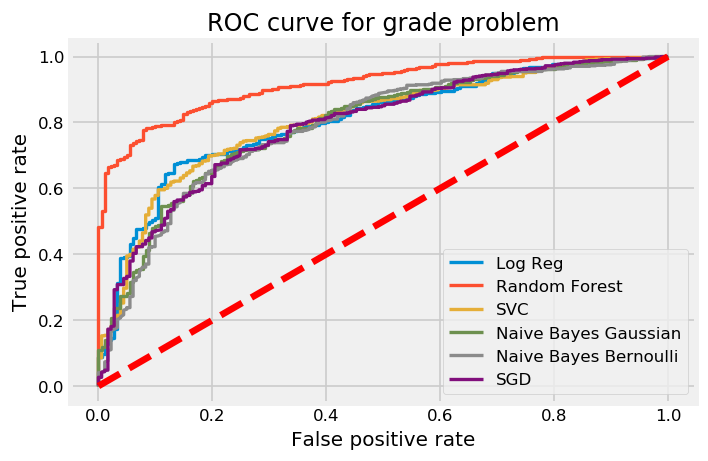

In [182]:
plt.figure(dpi=120)
#plt.plot(fpr_knn, tpr_knn, lw=2, label='KNN')
plt.plot(fpr_LogReg, tpr_LogReg, lw=2, label='Log Reg')
plt.plot(fpr_RandFor, tpr_RandFor, lw=2, label='Random Forest')
plt.plot(fpr_SVC, tpr_SVC, lw=2, label='SVC')
plt.plot(fpr_NBG, tpr_NBG, lw=2, label='Naive Bayes Gaussian')
plt.plot(fpr_NBB, tpr_NBB, lw=2, label='Naive Bayes Bernoulli')
plt.plot(fpr_SGD, tpr_SGD, lw=2, label='SGD')
plt.plot([0,1],[0,1],c='r',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend()


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for grade problem');

>> **It's decided! Random Forest and Naive Bayes (Bernoulli) are going through to the next round!**

In [183]:
#Let's record the two best models
Random_Forest = all_models['Random Forest']
Naive_Bayes_B = all_models['Naive Bayes Bernoulli']

## Can we do better with oversampling?

#### Random Over Sampler 

In [184]:
ROS = RandomOverSampler(random_state=42)
feat_train_ROS, grade_label_train_ROS = ROS.fit_sample(feat_train, grade_label_train)

In [185]:
Counter(grade_label_train_ROS)

Counter({1: 643, 0: 643})

In [186]:
#Create a new Random Forest model and fit with "oversampled" values
Random_Forest_ROS = RandomForestClassifier(n_estimators=150, class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=2, random_state=42)
Random_Forest_ROS.fit(feat_train_ROS, grade_label_train_ROS)

Naive_Bayes_B_ROS = Naive_Bayes_B
Naive_Bayes_B_ROS.fit(feat_train_ROS, grade_label_train_ROS);

The scores on original training set are:

Accuracy score after Random Over Sampler is: 0.829
Recall score after Random Over Sampler is: 0.865
Precision score after Random Over Sampler is: 0.911
F1 score after Random Over Sampler is: 0.887


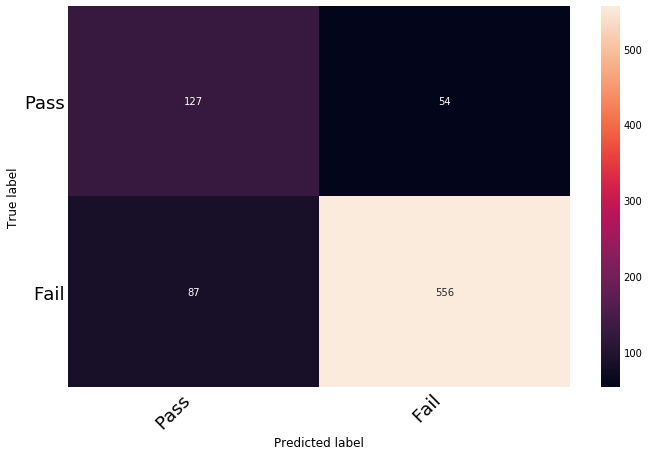

In [187]:
print('The scores on original training set are:\n')
print('Accuracy score after Random Over Sampler is:', colored(str(round(Random_Forest_ROS.score(feat_train, grade_label_train), 3)), 'magenta'))
print('Recall score after Random Over Sampler is:', colored(str(round(recall_score(
                                        grade_label_train, Random_Forest_ROS.predict(feat_train)), 3)), 'magenta'))
print('Precision score after Random Over Sampler is:', colored(str(round(precision_score(
                                        grade_label_train, Random_Forest_ROS.predict(feat_train)), 3)), 'green'))
print('F1 score after Random Over Sampler is:', colored(str(round(f1_score(
                                        grade_label_train, Random_Forest_ROS.predict(feat_train)), 3)), 'magenta'))

RF_ROS_cm = confusion_matrix(grade_label_train, Random_Forest_ROS.predict(feat_train))
RF_ROS_cm = print_confusion_matrix(RF_ROS_cm, ['Pass', 'Fail'])

> Not with Random Over Sampler, apparently!

#### SMOTE

In [188]:
SMO = SMOTE(random_state=42)
feat_train_smoted, grade_label_train_smoted = SMO.fit_sample(feat_train, grade_label_train)

In [189]:
Counter(grade_label_train_smoted)

Counter({1: 643, 0: 643})

In [190]:
Random_Forest_SMOTE = RandomForestClassifier(n_estimators=150, class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=2, random_state=42)
Random_Forest_SMOTE.fit(feat_train_smoted, grade_label_train_smoted)

Naive_Bayes_B_SMOTE = Naive_Bayes_B
Naive_Bayes_B_SMOTE.fit(feat_train_smoted, grade_label_train_smoted);

Test scores on original training set are:

Accuracy score after SMOTE is: 0.856
Recall score after SMOTE is: 0.911
Precision score after SMOTE is: 0.904
F1 score after SMOTE is: 0.908


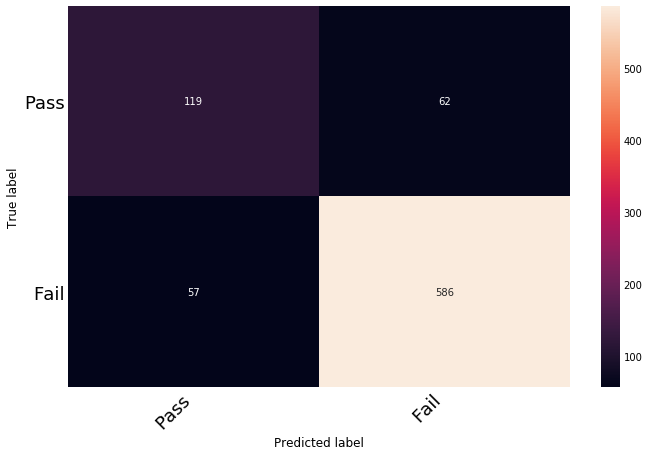

In [191]:
print('Test scores on original training set are:\n')
print('Accuracy score after SMOTE is:', colored(str(round(Random_Forest_SMOTE.score(feat_train, grade_label_train), 3)), 'magenta'))
print('Recall score after SMOTE is:', colored(str(round(recall_score(
                                        grade_label_train, Random_Forest_SMOTE.predict(feat_train)), 3)), 'magenta'))
print('Precision score after SMOTE is:', colored(str(round(precision_score(
                                        grade_label_train, Random_Forest_SMOTE.predict(feat_train)), 3)), 'green'))
print('F1 score after SMOTE is:', colored(str(round(f1_score(
                                        grade_label_train, Random_Forest_SMOTE.predict(feat_train)), 3)), 'magenta'))

#What's my confusion matrix looking like?
RF_smoted_cm = confusion_matrix(grade_label_train, Random_Forest_SMOTE.predict(feat_train))
RF_smoted_cm = print_confusion_matrix(RF_smoted_cm, ['Pass', 'Fail'])

> Not much improvement with SMOTE

#### ADASYN

In [192]:
ADA = ADASYN(random_state=42)
feat_train_adasyn, grade_label_train_adasyn = ADA.fit_sample(feat_train, grade_label_train)

In [193]:
Counter(grade_label_train_adasyn)

Counter({1: 643, 0: 650})

In [194]:
Random_Forest_ADASYN = RandomForestClassifier(n_estimators=150, class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=2, random_state=42)
Random_Forest_ADASYN.fit(feat_train_adasyn, grade_label_train_adasyn)

Naive_Bayes_B_ADASYN = Naive_Bayes_B
Naive_Bayes_B_ADASYN.fit(feat_train_adasyn, grade_label_train_adasyn);

Test scores on original training set are:

Accuracy score after ADASYN is: 0.859
Recall score after ADASYN is: 0.928
Precision score after ADASYN is: 0.895
F1 score after ADASYN is: 0.911


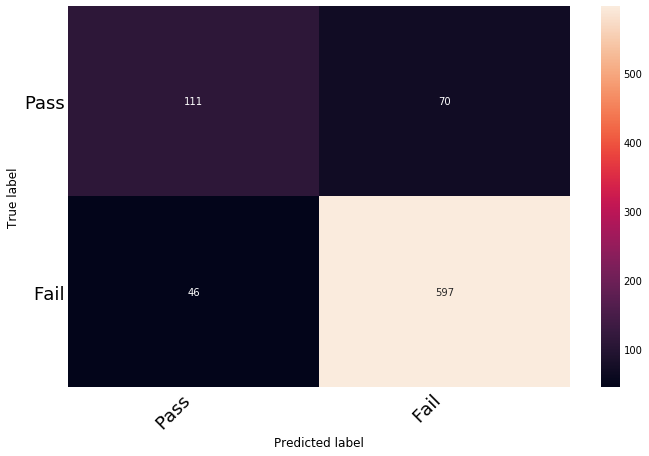

In [195]:
print('Test scores on original training set are:\n')
print('Accuracy score after ADASYN is:', colored(str(round(Random_Forest_ADASYN.score(feat_train, grade_label_train), 3)), 'magenta'))
print('Recall score after ADASYN is:', colored(str(round(recall_score(
                                        grade_label_train, Random_Forest_ADASYN.predict(feat_train)), 3)), 'magenta'))
print('Precision score after ADASYN is:', colored(str(round(precision_score(
                                        grade_label_train, Random_Forest_ADASYN.predict(feat_train)), 3)), 'green'))
print('F1 score after ADASYN is:', colored(str(round(f1_score(
                                        grade_label_train, Random_Forest_ADASYN.predict(feat_train)), 3)), 'magenta'))

#What's my confusion matrix looking like?
RF_adasyn_cm = confusion_matrix(grade_label_train, Random_Forest_ADASYN.predict(feat_train))
RF_adasyn_cm = print_confusion_matrix(RF_adasyn_cm, ['Pass', 'Fail'])

### So does Oversampling help?

In [150]:
mini_model_list = [Random_Forest, Random_Forest_ROS, Random_Forest_SMOTE, Random_Forest_ADASYN, Naive_Bayes_B, Naive_Bayes_B_ROS
                  , Naive_Bayes_B_SMOTE, Naive_Bayes_B_ADASYN]
mini_model_names = ['RF', 'RF with ROS', 'RF with SMOTE', 'RF with ADASYN', 'Naive Bayes Bernoulli', 'NBB with ROS', 'NBB with SMOTE', 'NBB with ADASYN']

kfold = KFold(random_state=42)
oversample_model_scores = []

for i in range(len(mini_model_list)):
    try_model = mini_model_list[i]
    for train_index, test_index in kfold.split(feat_train):
        kfeat_train = feat_train.iloc[train_index]
        kfeat_test = feat_train.iloc[test_index]
        kgrade_train = grade_label_train.iloc[train_index]
        kgrade_test = grade_label_train.iloc[test_index]
        precision = precision_score(kgrade_test, try_model.predict(kfeat_test))
        oversample_model_scores.append((mini_model_names[i], round(np.mean(precision), 3)))
    
print(oversample_model_scores)

TypeError: 'numpy.float64' object is not callable

In [ ]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []

    
for train_index, test_index in kf.split(X_smoted_last):

    kX_train = X_smoted_last.iloc[train_index]
    kX_test = X_smoted_last.iloc[test_index]
    ky_train = y_smoted_last.iloc[train_index]
    ky_test = y_smoted_last.iloc[test_index]

    y_predict = svc1.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)


print('Scores with SMOTE Oversampling -- SVC SMOTED LESS FEATURES')
print(f'accuracy: {accuracy} precision: {precision}')
print('')

> Shocker!

## Feature selection (with Random Forest)

In [47]:
feat_imp = []
for feat, imp in zip([f for f in feat_train.columns], Random_Forest.feature_importances_):
    feat_imp.append((feat, round(imp, 3)))

for feat, imp in sorted(feat_imp, key=lambda x: x[1], reverse=True):
    print(str(feat)+':', str(imp))

failures: 0.27
discipline: 0.089
absences: 0.086
higher: 0.07
goout: 0.039
Fedu: 0.038
famrel: 0.037
Medu: 0.034
age: 0.033
freetime: 0.033
Walc: 0.031
studytime: 0.028
Dalc: 0.027
health: 0.022
guardian: 0.021
paid: 0.021
sex: 0.018
schoolsup: 0.018
address: 0.017
famsize: 0.014
traveltime: 0.013
romantic: 0.013
activities: 0.011
famsup: 0.008
internet: 0.007
Pstatus: 0.002
